# The biharmonic equation on the Torus

The biharmonic equation is given as

$$
\nabla^4 u = f,
$$

where $u$ is the solution and $f$ is a function. In this notebook we will solve this equation  inside a torus with homogeneous boundary conditions $u(r=1)=u'(r=1)=0$ on the outer surface. We solve the equation with the spectral Galerkin method in curvilinear coordinates. 

<img src="https://cdn.jsdelivr.net/gh/spectralDNS/spectralutilities@master/figures/torus2.png">

The torus is parametrized by    

\begin{align*}
x(r, \theta, \phi) &= (R + r \cos \theta) \cos \phi \\
y(r, \theta, \phi) &= (R + r \cos \theta) \sin \phi \\
z(r, \theta, \phi) &= r \sin \theta
\end{align*}

where the Cartesian domain is $\Omega = \{(x, y, z): \left(\sqrt{x^2+y^2} - R^2\right)^2 + z^2  < 1\}$ and the computational domain is $(r, \theta, \phi) \in D = [0, 1] \times [0, 2\pi] \times [0, 2\pi]$. Hence $\theta$ and $\phi$ are angles which make a full circle, so that their values start and end at the same point, $R$ is the distance from the center of the tube to the center of the torus,
$r$ is the radius of the tube. Note that $\theta$ is the angle in the small circle (around its center), whereas $\phi$ is the angle of the large circle, around origo.

We start the implementation by importing necessary functionality from shenfun and sympy and then defining the coordinates of the surface of the torus. 

In [1]:
from shenfun import *
from shenfun.la import SolverGeneric2ND
import sympy as sp
from IPython.display import Math

N = 24
R = 3
r, theta, phi = psi = sp.symbols('x,y,z', real=True, positive=True)
rv = ((R + r*sp.cos(theta))*sp.cos(phi), (R + r*sp.cos(theta))*sp.sin(phi), r*sp.sin(theta)) 

def discourage_powers(expr):
    POW = sp.Symbol('POW')
    count = sp.count_ops(expr, visual=True)
    count = count.replace(POW, 100)
    count = count.replace(sp.Symbol, type(sp.S.One))
    return count

B0 = FunctionSpace(N, 'L', basis='UpperDirichletNeumann', domain=(0, 1))
B1 = FunctionSpace(N, 'F', dtype='D', domain=(0, 2*np.pi))
B2 = FunctionSpace(N, 'F', dtype='d', domain=(0, 2*np.pi))
T = TensorProductSpace(comm, (B0, B1, B2), coordinates=(psi, rv, sp.Q.positive(r*sp.cos(theta)+R), (), discourage_powers))
T.coors.sg

x*(x*cos(y) + 3)

We use Fourier basis functions for the two periodic directions, and a Legendre basis that satisfies the homogeneous boundary conditions for the radial direction.

Note that `rv` represents the position vector $\vec{r}=x\mathbf{i} + y\mathbf{j} + z\mathbf{k}$ and that `T.hi` now contains the 3 scaling factors for the torus coordinates:

\begin{align*}
h_r &= \left|\frac{\partial \vec{r}}{\partial r}\right| = 1\\
h_{\theta} &= \left|\frac{\partial \vec{r}}{\partial \theta}\right| = r\\
h_{\phi} &= \left|\frac{\partial \vec{r}}{\partial \phi}\right| = r\cos \theta + R\\
\end{align*}

The covariant basis vectors used by shenfun are

In [2]:
T.coors.sg

x*(x*cos(y) + 3)

In [3]:
Math(T.coors.latex_basis_vectors(covariant=True, symbol_names={r: 'r', theta: '\\theta', phi: '\\phi'}))

<IPython.core.display.Math object>

Now check what the biharmonic operator looks like for the torus. Simplify equation using the integral measure $\sqrt{g}$, found as `T.coors.sg`

$$
\sqrt{g} = r (r \cos \theta + R)
$$

In [4]:
u = TrialFunction(T)
v = TestFunction(T)

In [5]:
du = div(grad(div(grad(u))))
g = sp.Symbol('g', real=True, positive=True)
replace = [(r*sp.cos(theta)+R, sp.sqrt(g)/r), (2*r*sp.cos(theta)+R, 2*sp.sqrt(g)/r-R)] # to simplify the look
Math((du*T.coors.sg**4).tolatex(symbol_names={r: 'r', theta: '\\theta', phi: '\\phi'}, replace=replace))

<IPython.core.display.Math object>

Glad you're not doing this by hand? 

To solve this equation we need to get a variational form that is separable. To get a variational form we multiply the equation by a weight $\omega$ and the complex conjugate of a test function $\overline{v}$, and integrate over the domain by switching to computational coordinates

\begin{align*}
\int_{\Omega} \nabla^4 u\, \overline{v} \omega dV &= \int_{\Omega} f \, \overline{v} \omega dV \\ 
\int_{D} \nabla^4 u \, \overline{v} \omega \sqrt{g} dr d\theta d\phi &= \int_{D} f \, \overline{v} \omega \sqrt{g} dr d\theta d\phi
\end{align*}


<div class="alert alert-warning">
    Note that the functions in the last equation now actually are transformed to computational space, i.e., $u=u(\mathbf{x}(r, \theta, \phi))$ and the same for the rest. We should probably use a new name for the transformed functions, but we keep the same here to keep it simple. Whether the function is transformed or not should be evident from context. If the integral is in computational space, then the functions are transformed.
</div>

For Legendre and Fourier test functions the weight $\omega$ is normally a constant. However, we see that the denominator in some terms above contains $g^2=r^4(r\cos \theta +R)^4$. The term in parenthesis $(r\cos \theta +R)$ makes the variational form above unseparable. If, on the other hand, we change the weight $\omega$ to $g^{3/2}$, then the misbehaving denominator disappears and the variational form becomes separable. 

$$
\int_{D} \nabla^4 u \, \overline{v} \, g^2 dr d\theta d\phi = \int_{D} f \, \overline{v} \, g^2 dr d\theta d\phi
$$

Alternatively, we can aim at only removing the $(r\cos \theta +R)$ term from the denominator by using weight $(r\cos \theta +R)^3$

$$
\int_{D} \nabla^4 u \, \overline{v} \, r (r\cos \theta +R)^4 dr d\theta d\phi = \int_{D} f \, \overline{v} \, r \,(r\cos \theta + R)^4 dr d\theta d\phi.
$$

The first actually leads to a coefficient matrix of fewer bands than the second. However, the condition number is larger and round-off errors more severe. In the code below we use the first approach by default, but it can be easily changed with the commented out code. 

We verify the implementation by using a manufactured solution that satisfies the boundary conditions. Note that the Legendre basis `ShenBiPolar0Basis`, chosen using `bc='BiPolar0'` with the `Basis`, currently is the only function space in shenfun that can satisfy $u(r=1, \theta, \phi)=u'(r=1, \theta, \phi)=u'(0, \theta, \phi)=0$, where the latter is a pole condition inherited from [Shen's paper on cylindrical coordinates](https://epubs.siam.org/doi/abs/10.1137/S1064827595295301). With the current weights the pole condition is probably not needed.

In [6]:
#ue = sp.sin(theta*2)*sp.cos(4*phi)*((1-r))**2 #+B0.sympy_basis(4, x=r)
#ue = (1-sp.exp(-(1-r)**2))**2*sp.cos(4*phi)
xx = r*sp.cos(theta); yy = r*sp.sin(theta)
ue = ((1-r)*sp.exp(-(xx-0.4)**2-(yy-0.3)**2))**2*sp.cos(2*phi)
f = div(grad(div(grad(u)))).tosympy(basis=ue, psi=psi)
fj = Array(T, buffer=f*T.coors.sg**3)
#fj = Array(T, buffer=f*T.hi[2]**3)
f_hat = Function(T)
f_hat = inner(v, fj, output_array=f_hat)
#M = inner(v*T.hi[2]**3, div(grad(div(grad(u)))))
#M = inner(v*T.coors.sg**3, div(grad(div(grad(u)))))
M = inner(div(grad(v*T.coors.sg**3)), div(grad(u)))

u_hat = Function(T)
sol = la.SolverGeneric2ND(M)
u_hat = sol(f_hat, u_hat)
uj = u_hat.backward()
uq = Array(T, buffer=ue)
print('Error =', np.sqrt(inner(1, (uj-uq)**2)))

Error = 0.01614033674285722


Note that the variational form contains

In [7]:
len(M)

136

tensorproduct matrices, but some differ only in the scales. The solver `SolverGeneric2ND` loops over and solves for one Fourier coefficient in the $\phi$-direction at the time, because all submatrices in the $\phi$-direction are diagonal. The matrices in the $\theta$-direction are not necessarily diagonal because of the weight $(r\cos \theta + 3)$. The sparsity pattern of the matrix can be inspected as follows

<IPython.core.display.Javascript object>


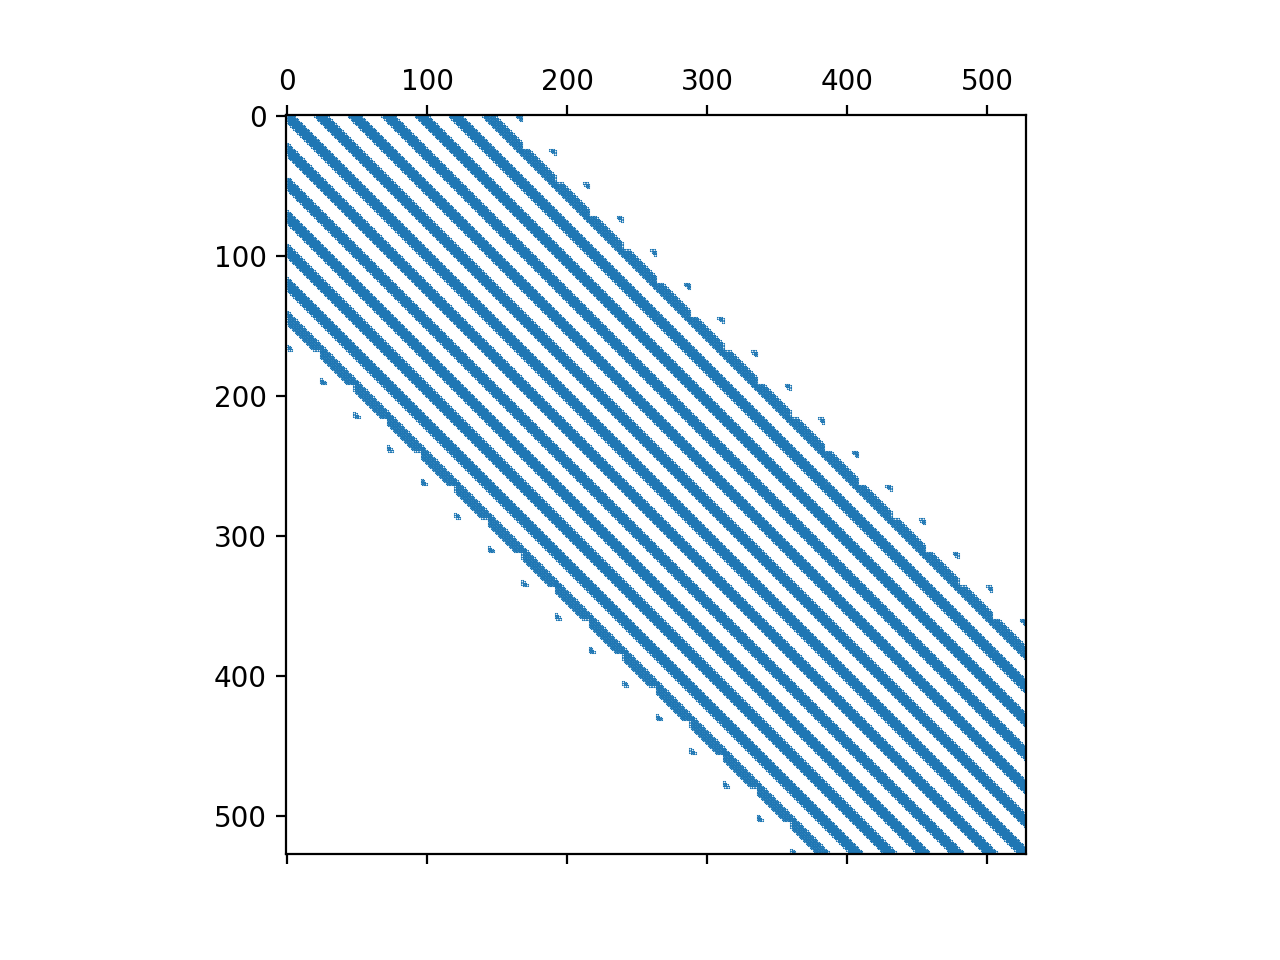

In [8]:
import matplotlib.pyplot as plt
%matplotlib notebook
B = sol.diags(4)
#print(np.linalg.cond(B.toarray()))
plt.spy(B, markersize=0.1)
plt.show()

A baded matrix in deed, but quite a large number of bands.

A slice of the solution can be visualized. Here we use $\phi=0$, because that lies in the Cartesian $x-z$-plane.

<IPython.core.display.Javascript object>


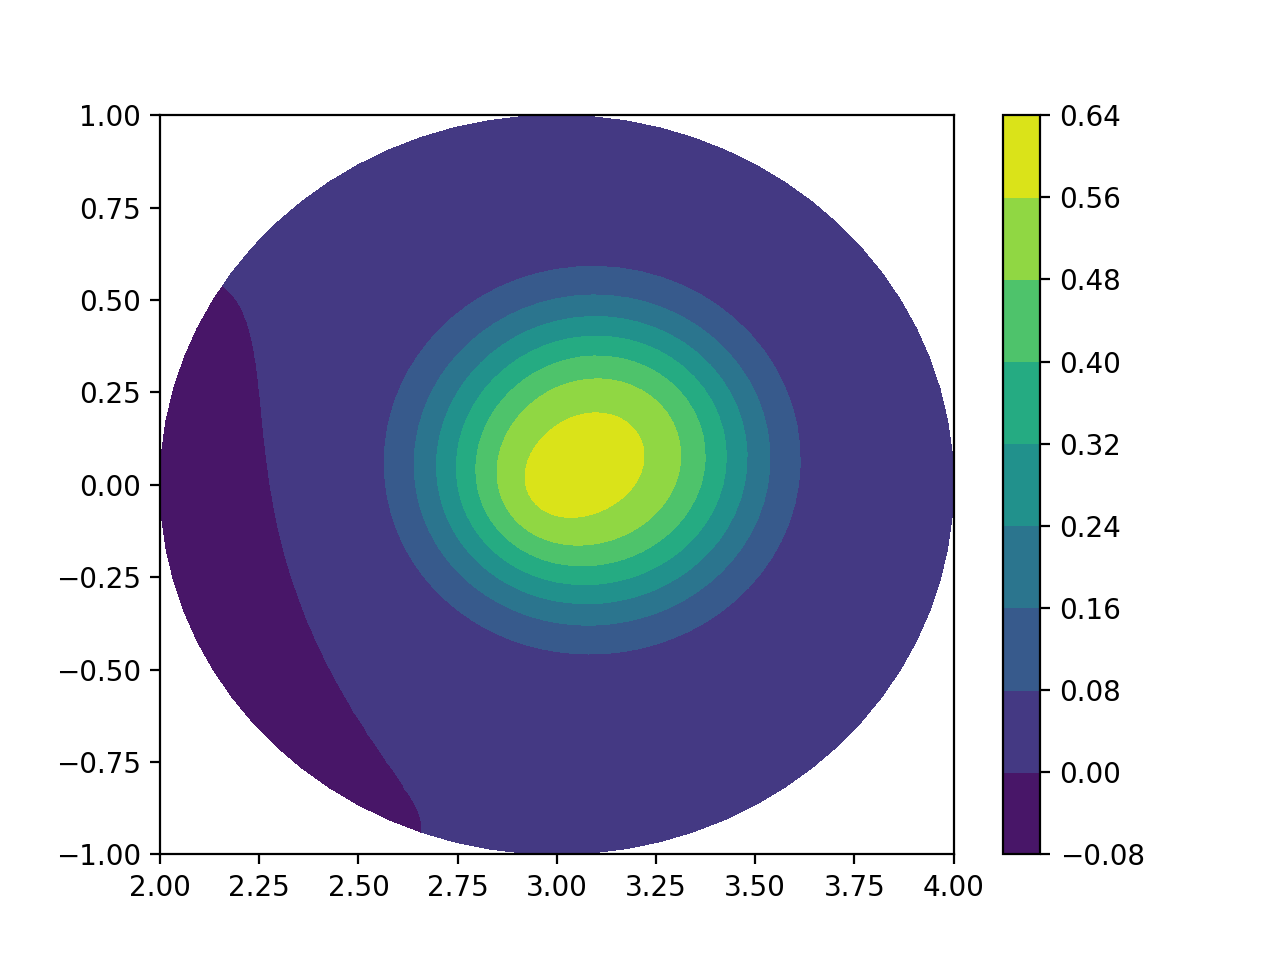

In [9]:
u_hat2 = u_hat.refine([N*3, N*3, N])
ur = u_hat2.backward()
us = ur.get((slice(None), slice(None), 0))
xx, yy, zz = u_hat2.function_space().local_cartesian_mesh(uniform=True)

# Wrap periodic plot around since it looks nicer
xp = np.hstack([xx[:, :, 0], xx[:, 0, 0][:, None]])
zp = np.hstack([zz[:, :, 0], zz[:, 0, 0][:, None]])
up = np.hstack([us, us[:, 0][:, None]])

# plot
plt.figure()
plt.contourf(xp, zp, up)
plt.colorbar()


Now print the solution at approximately half the radius

In [10]:
from mayavi import mlab
u_hat3 = u_hat.refine([N, N*3, N*3])
ux = u_hat3.backward()
X = u_hat3.function_space().local_mesh(broadcast=True, uniform=True)
print('radius =',X[0][N//2,0,0])

radius = 0.5217391304347826


Get the $\theta-\phi$ mesh for given radius

In [11]:
xj = []
for rv in T.coors.coordinates[1]:
    xj.append(sp.lambdify(psi, rv)(X[0][N//2], X[1][N//2], X[2][N//2]))
xx, yy, zz = xj
us = ux[N//2]

Wrap around periodic direction to make it nicer

In [12]:
xx = np.hstack([xx, xx[:, 0][:, None]])
yy = np.hstack([yy, yy[:, 0][:, None]])
zz = np.hstack([zz, zz[:, 0][:, None]])
us = np.hstack([us, us[:, 0][:, None]])
xx = np.vstack([xx, xx[0]])
yy = np.vstack([yy, yy[0]])
zz = np.vstack([zz, zz[0]])
us = np.vstack([us, us[0]])
mlab.figure(bgcolor=(1, 1, 1))
mlab.mesh(xx, yy, zz, scalars=us, colormap='jet')
mlab.show()

## Vector Laplacian

Finally, we look at the vector Laplacian and verify the following

$$
\nabla^2 \vec{u} = \nabla \nabla \cdot \vec{u} - \nabla \times \nabla \times \vec{u}
$$

The vector Laplace $\nabla^2 \vec{u}$ looks like: 

In [13]:
V = VectorSpace(T)
p = TrialFunction(V)
du = div(grad(p))
replace = [(r*sp.cos(theta)+R, sp.sqrt(g)/r), (2*r*sp.cos(theta)+R, 2*sp.sqrt(g)/r-R)] # to simplify the look
Math(du.tolatex(symbol_names={r: 'r', theta: '\\theta', phi: '\\phi'}, replace=replace))

<IPython.core.display.Math object>

And if we subtract $\nabla \nabla \cdot \vec{u} - \nabla \times \nabla \times \vec{u}$ we should get the zero vector.

In [14]:
dv = grad(div(p)) - curl(curl(p))
dw = du-dv
dw.simplify()
Math(dw.tolatex(symbol_names={r: 'r', theta: '\\theta', phi: '\\phi'}))

<IPython.core.display.Math object>